In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
import imageio
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('cleaned_data.csv', index_col='Unnamed: 0')

In [3]:
# set year, month, quarter columns
df['year'] = df['time'].apply(lambda x: x[:4])
df['month'] = df['time'].apply(lambda x:x[5:7])
df['quarter'] = df['month'].apply(lambda x: (int(x)-1)//3+1)

In [4]:
# drop 2018 films 
df = df[~(df['year']=='2018')]

# Basic Analysis

## Great films & Box office over year

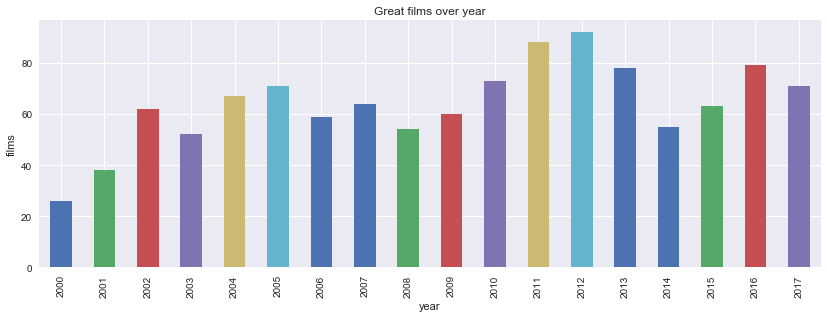

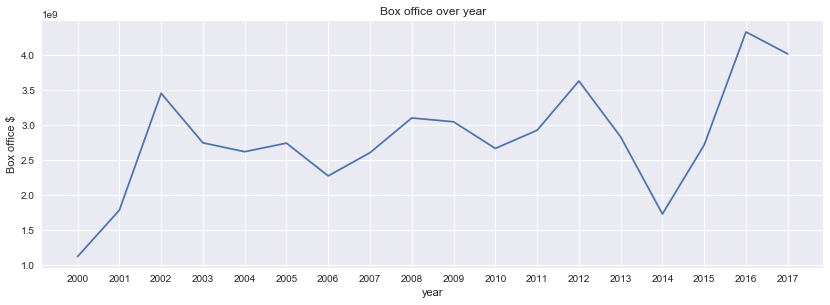

In [5]:
plt.style.use('seaborn')

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
df.groupby(df['year']).size().plot(kind='bar')
plt.xlabel('year')
plt.ylabel('films')
plt.title('Great films over year')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2)
plt.plot(df[['year','box_office']].groupby('year').sum())
plt.xlabel('year')
plt.ylabel('Box office $')
plt.title('Box office over year')
plt.show()

## genre trend of great movies

### genre data processing

In [6]:
def get_columns(df_column):
    l = []
    for ele in df_column:
        if ele!='na' and ele!='nan':
            l.extend(ele.split(', '))

    return set([x[1:-1] for x in l])

genre_list = get_columns(df['genre'])
for ele in genre_list:
    df['genre_'+str(ele)]=np.where(df["genre"].str.contains(ele),1,0)

df['genre_Total'] = df['genre'].apply(lambda x: len(x.split(', ')))

### genre wordcloud

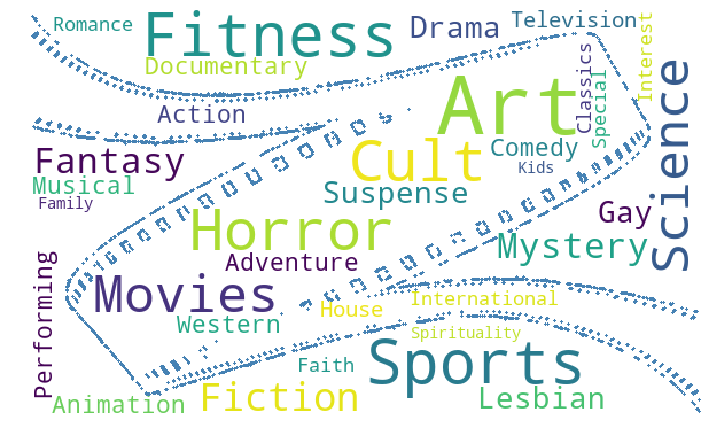

In [7]:
string = ' '.join(genre_list)
words=nltk.tokenize.word_tokenize(string)
origin_mask = imageio.imread("films.jpg")
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',mask=origin_mask, contour_width=3, 
               contour_color='steelblue').generate(' '.join(words))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Genre and box office distribution

In [8]:
genre_list = [str('genre_'+x) for x in genre_list]

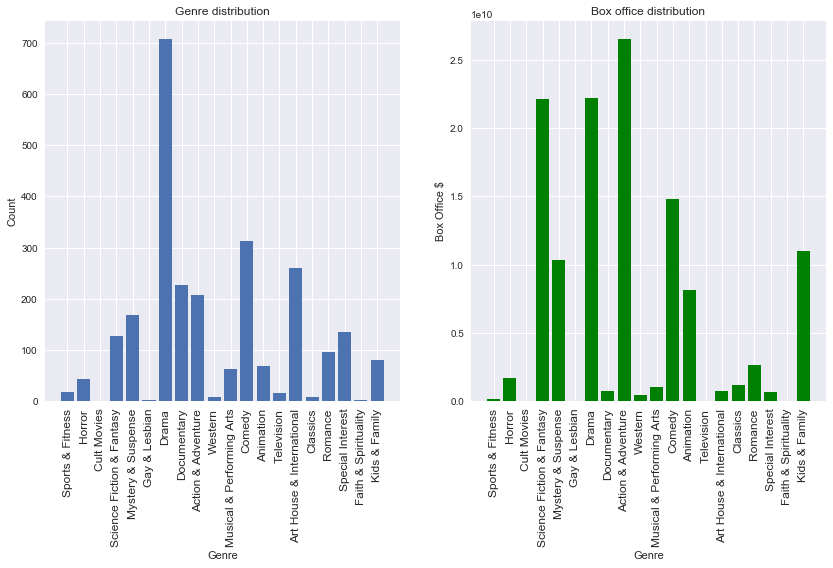

In [9]:
genre_count = {}
box_office = {}

for genre in genre_list:
    genre_count[genre[6:]] = len(df[df[genre]==1])
    box_office[genre[6:]] = sum(df[df[genre]==1]['box_office'])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.bar(genre_count.keys(),genre_count.values())
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre distribution')
plt.xticks(rotation=90,fontsize=12)

plt.subplot(1,2,2)
plt.bar(box_office.keys(),box_office.values(),color='G')
plt.xlabel('Genre')
plt.ylabel('Box Office $')
plt.title('Box office distribution')
plt.xticks(rotation=90,fontsize=12)

plt.show()

### genre trend over year

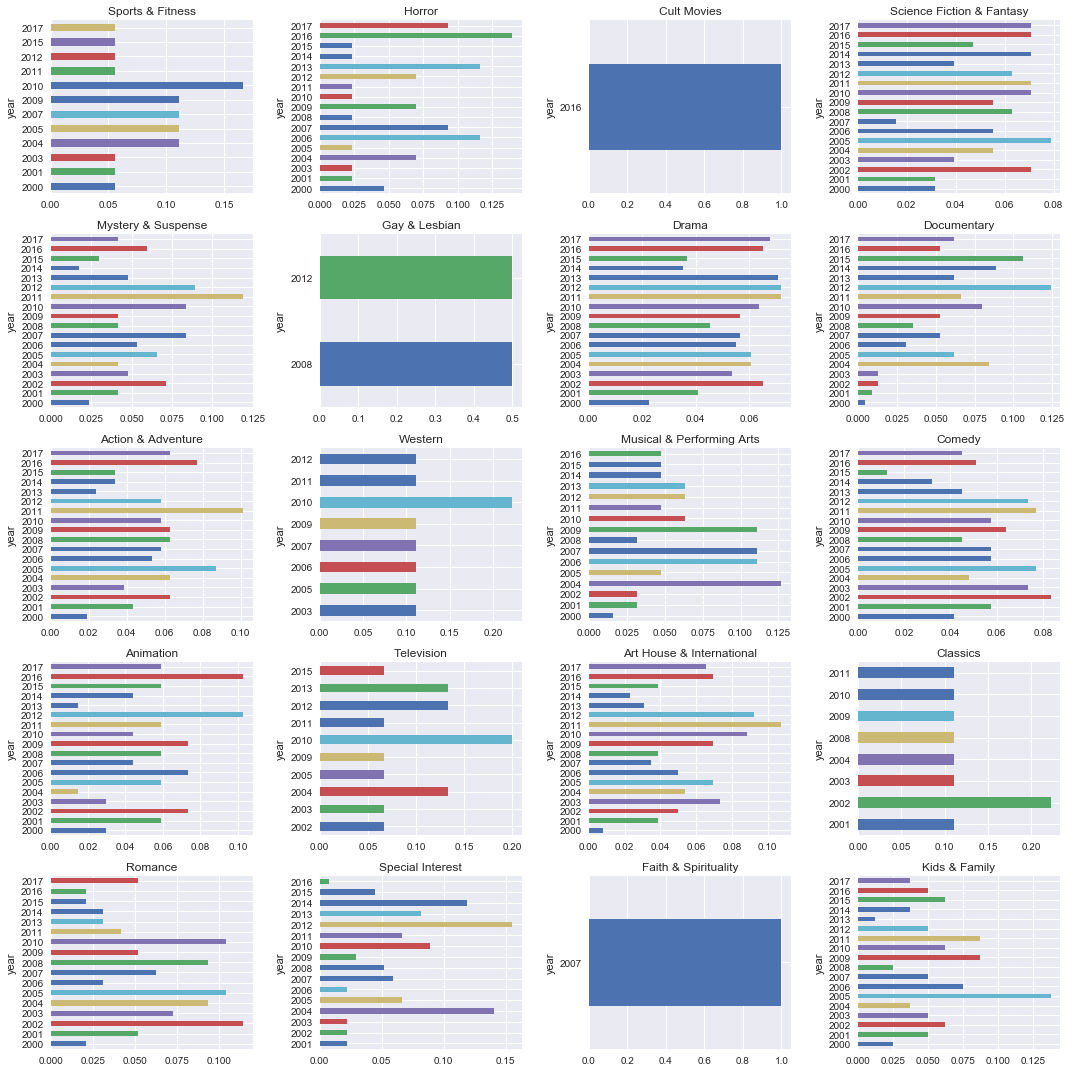

In [10]:
from matplotlib.ticker import FuncFormatter
COL_NUM = 4
ROW_NUM = 5
fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i, ele in enumerate(genre_list):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    ele_trend_ratio = df[df[ele]==1].groupby(df['year']).size() / len(df[df[ele]==1])
    ele_trend_ratio.plot(kind='barh',ax=ax)
    ax.set_title(ele[6:])

plt.tight_layout() 

### genre trend over quarter

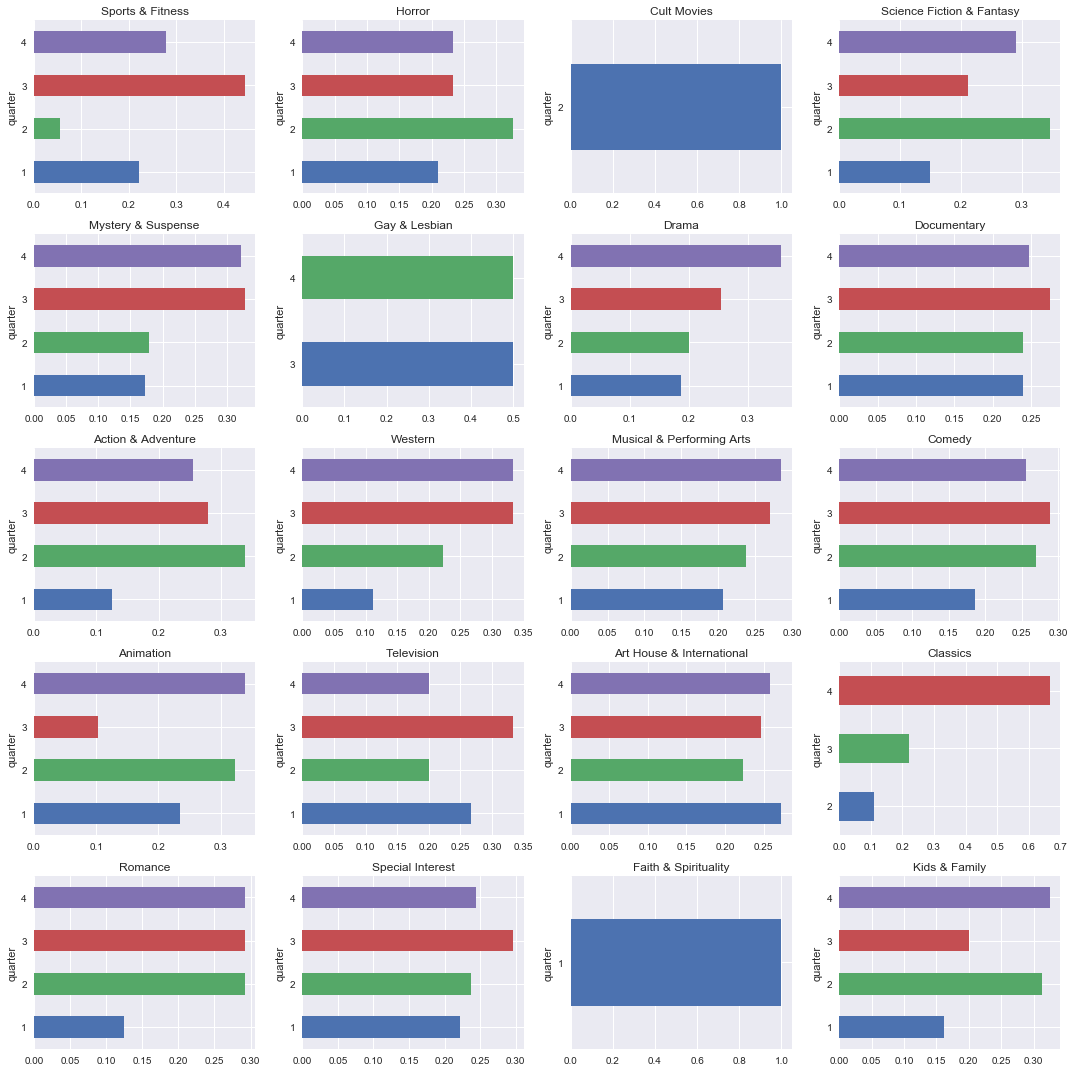

In [11]:
from matplotlib.ticker import FuncFormatter
COL_NUM = 4
ROW_NUM = 5
fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i, ele in enumerate(genre_list):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    ele_trend_ratio = df[df[ele]==1].groupby(df['quarter']).size() / len(df[df[ele]==1])
    ele_trend_ratio.plot(kind='barh',ax=ax)
    ax.set_title(ele[6:])

plt.tight_layout() 

## Rating distribution

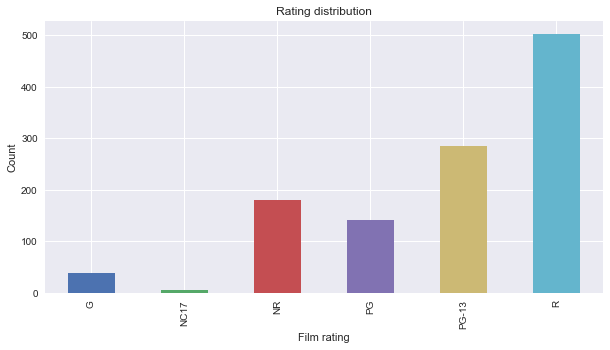

In [12]:
plt.figure(figsize=(10,5))
df.groupby(['rating']).size().plot(kind='bar')
plt.xlabel('Film rating')
plt.ylabel('Count')
plt.title('Rating distribution')
plt.show()

## Director explorations

### Director data processing

In [13]:
dic = {}
for directors in df['director']:
    director_list = directors.split(', ')
    for director in director_list:
        dic[director] = dic.get(director,0)+1
dic = sorted(dic.items(),key=lambda x:x[1],reverse=True)

top_director = [x for x in dic if x[1]>=7]
print('Top Directors: ',top_director, '\n')
director_name = top_director[0][0][1:-1]
print('Number One Director: ',director_name)

Top Directors:  [("'Joel Coen'", 10), ("'Steven Soderbergh'", 8), ("'Christopher Nolan'", 7), ("'Jon Favreau'", 7), ("'Werner Herzog'", 7)] 

Number One Director:  Joel Coen


### Brief look at top directors' preference on genre

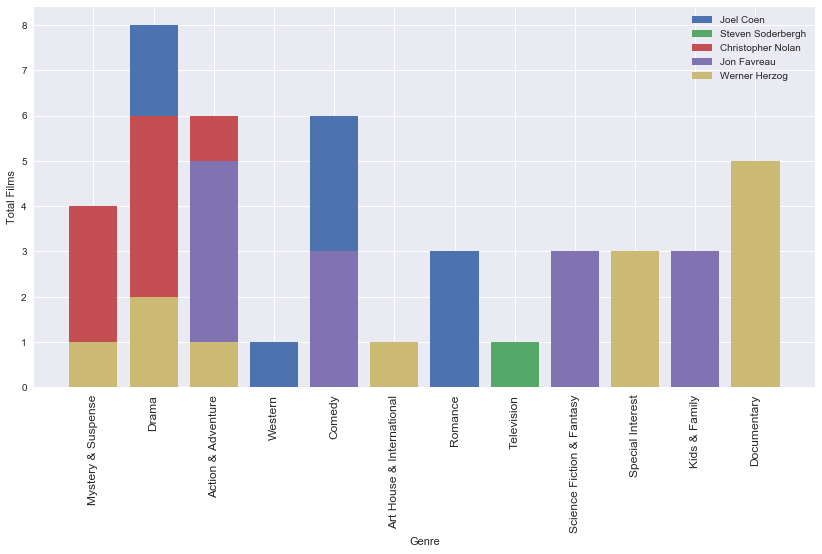

In [14]:
plt.figure(figsize=(14,7))
for director in top_director:
    sub_df = df[[director[0] in directors for directors in [ele.split(', ') for ele in df['director']]]]
    record = {}
    for genre in genre_list:
        count = sum(sub_df[genre_list][genre])
        if count>0:
            record[genre[6:]]=count
    plt.bar(record.keys(),record.values(),label=director[0][1:-1])

plt.legend(loc='upper right')
plt.xlabel('Genre')
plt.ylabel('Total Films')
plt.xticks(rotation=90,fontsize=12)
plt.show()

### Look closer into director 'Joel Choen'

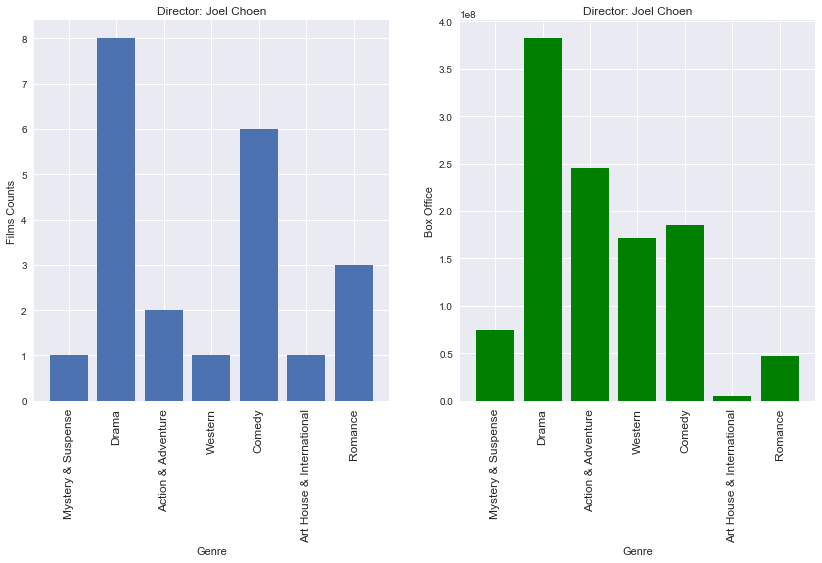

In [15]:
df_JC = df[["'Joel Coen'" in directors for directors in [ele.split(', ') for ele in df['director']]]]

record = {}
box_office = {}
for genre in genre_list:
    count = sum(df_JC[genre_list][genre])
    if count>0:
        record[genre[6:]] = count
        box_office[genre[6:]] = sum(df_JC[df_JC[genre]==1]['box_office'])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.bar(record.keys(),record.values())
plt.xlabel('Genre')
plt.ylabel('Films Counts')
plt.title('Director: Joel Choen')
plt.xticks(rotation=90,fontsize=12)

plt.subplot(1,2,2)
plt.bar(box_office.keys(),box_office.values(),color='G')
plt.xlabel('Genre')
plt.ylabel('Box Office')
plt.title('Director: Joel Choen')
plt.xticks(rotation=90,fontsize=12)

plt.show()